In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from pandas.plotting import scatter_matrix
import requests
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from src.iex_api import sector_get
from time import sleep
from regression_tools.plotting_tools import (
    plot_univariate_smooth,
    bootstrap_train,
    display_coef,
    plot_bootstrap_coefs,
    plot_partial_depenence,
    plot_partial_dependences,
    predicteds_vs_actuals)
import pickle
import seaborn as sns
from tsne_knn import *
% matplotlib inline 

In [3]:
X = pd.read_pickle('data/stocks_ratios.pkl')

In [4]:
X.columns

Index(['Share Price', 'Common Shares Outstanding',
       'Avg. Basic Shares Outstanding', 'Avg. Diluted Shares Outstanding',
       'Revenues', 'COGS', 'SG&A', 'R&D', 'EBIT', 'EBITDA',
       'Interest expense, net', 'Abnormal Gains/Losses', 'Income Taxes',
       'Net Income from Discontinued Op.', 'Net Profit', 'Dividends',
       'Cash and Cash Equivalents', 'Receivables', 'Current Assets',
       'Net PP&E', 'Intangible Assets', 'Goodwill', 'Total Noncurrent Assets',
       'Total Assets', 'Short term debt', 'Accounts Payable',
       'Current Liabilities', 'Long Term Debt', 'Total Noncurrent Liabilities',
       'Total Liabilities', 'Preferred Equity', 'Share Capital',
       'Treasury Stock', 'Retained Earnings', 'Equity Before Minorities',
       'Minorities', 'Total Equity', 'Depreciation & Amortisation',
       'Change in Working Capital', 'Cash From Operating Activities',
       'Net Change in PP&E & Intangibles', 'Cash From Investing Activities',
       'Cash From Financing

In [5]:
# Remove columns associated with share price
cols_to_remove = ['Share Price', 'Common Shares Outstanding','Avg. Basic Shares Outstanding', \
                  'Avg. Diluted Shares Outstanding','EV / EBITDA', 'EV / Sales', 'Book to Market',\
                  'Operating Income / EV', 'EV / EBITDA', 'EV / Sales', 'Book to Market', 'Operating Income / EV', \
                 'Enterprise Value']
X.drop(cols_to_remove, inplace=True, axis=1)

# Change from string types to numeric
column_names = X.columns
for i in range(len(column_names)):
    X[column_names[i]] = pd.to_numeric(X[column_names[i]])

In [6]:
# build list of sector labels for each stock
# ticker_list = X.index
# sector_list = []
# for ticker in ticker_list:
#     response = requests.get(f'https://api.iextrading.com/1.0/stock/{ticker}/company', \
#                         params={'filter':'sector'})
#     if response.status_code == 200:
#         sector_list.append(response.json()['sector'])
#     else:
#         sector_list.append('Unknown')
# # Add sector labels 
# X['Sector'] = sector_list
# with open('sectors.pkl', 'wb') as f:
#     pickle.dump(sector_list, f)

sector_list = pickle.load( open( "sectors.pkl", "rb" ) )

In [7]:
X['Sector'] = sector_list

In [8]:
sector_list.count('Unknown')

69

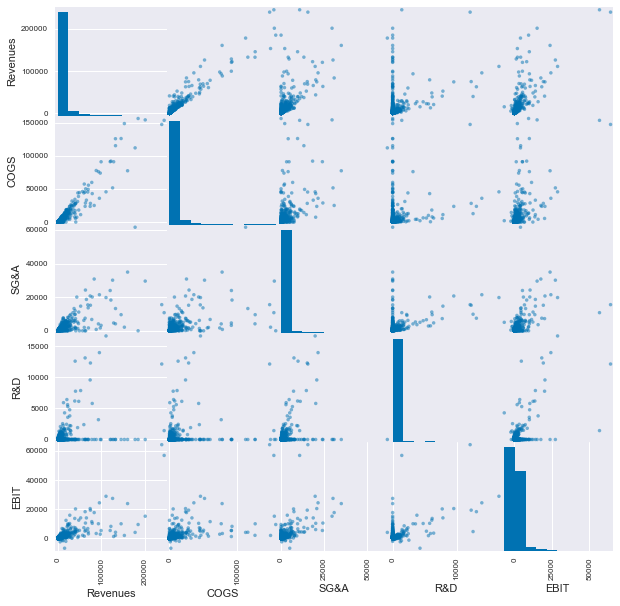

In [9]:
scatter_matrix(X.iloc[:,0:5], figsize=(10,10));

In [10]:
X_cluster_features = X[['Net Profit Margin', 'Return on Equity', 'Return on Assets',
       'Current Ratio', 'Liabilities to Equity Ratio', 'Debt to Assets Ratio']]
X_cluster_features = scaler(X_cluster_features)
X_scaled_embedded = TSNE(n_components=2).fit_transform(X_cluster_features)
n_clusters = 7
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1)
labels = clf.fit_predict(X_scaled_embedded)
labels = labels.reshape(1004,1)

In [ ]:
X_scaled_embedded_model = TSNE(n_components=2).fit(X_cluster_features)

In [12]:
X['Clusters'] = labels 
X['Clusters'] = X['Clusters'].astype(dtype='category')

In [13]:
# Add column of market cap labels 
X['Market Cap'] = pd.cut(X['Market Capitalisation'], [0, 2000000, 10000000, 200000000,1000000000],\
                     labels=['Small', 'Mid', 'Large', 'Mega'])

In [139]:
# fig, ax = plt.subplots()
cap_dict = {}
for cap in X['Market Cap'].unique():
    cap_dict[cap]= X[X['Market Cap'] == cap].shape[0]
# ax.bar(height=cap_list, left='Number of Stocks')

cap_dict

{'Large': 336, 'Mega': 17, 'Mid': 289, 'Small': 362}

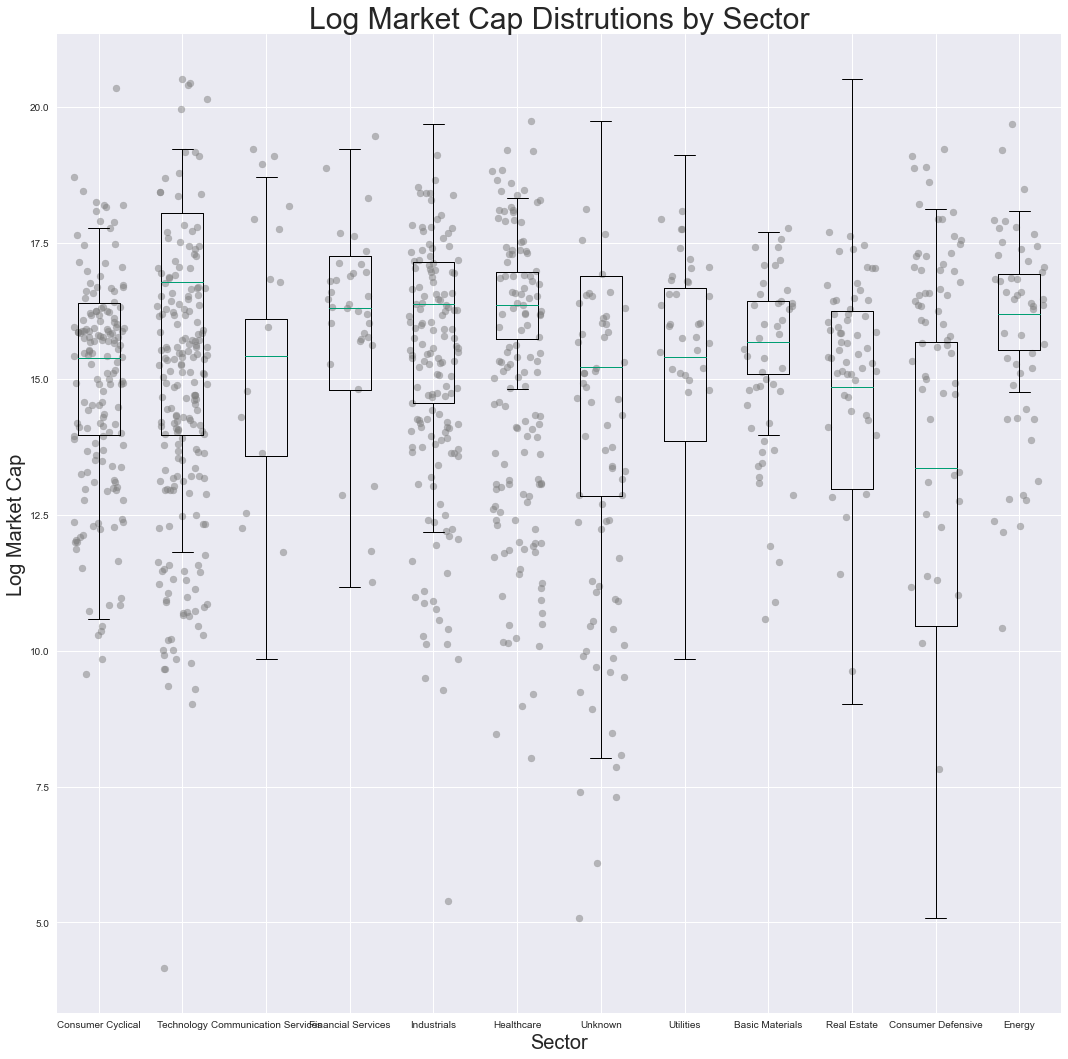

In [19]:
def convert_to_numeric(catagorical):
    classes = catagorical.unique()
    classes_mapping = {cls: i for i, cls in enumerate(classes)}
    classes_inv_mapping = {i: cls for i, cls in enumerate(classes)}
    classes_numeric = catagorical.apply(lambda cls: classes_mapping[cls])
    return classes_numeric, classes_inv_mapping

X['LogCap'] = np.log(X['Market Capitalisation'])

fig, ax = plt.subplots(figsize=(18, 18))

catagorical = X["Sector"]
y_log = X["LogCap"]

numeric, classes_mapping = convert_to_numeric(catagorical)

noise = np.random.uniform(-0.3, 0.3, size=len(catagorical))
ax.scatter(numeric + noise, y_log, color="grey", alpha=0.5)

box_data = list(y_log.groupby(catagorical))
ax.boxplot([data for _, data in box_data], positions=range(len(box_data)))
ax.set_xticks(list(classes_mapping))
ax.set_xticklabels(list(catagorical.unique()))

ax.set_xlabel("Sector", fontdict={'size':20})
ax.set_ylabel("Log Market Cap", fontdict={'size': 20})
ax.set_title("Log Market Cap Distrutions by Sector", fontdict={'size': 30})

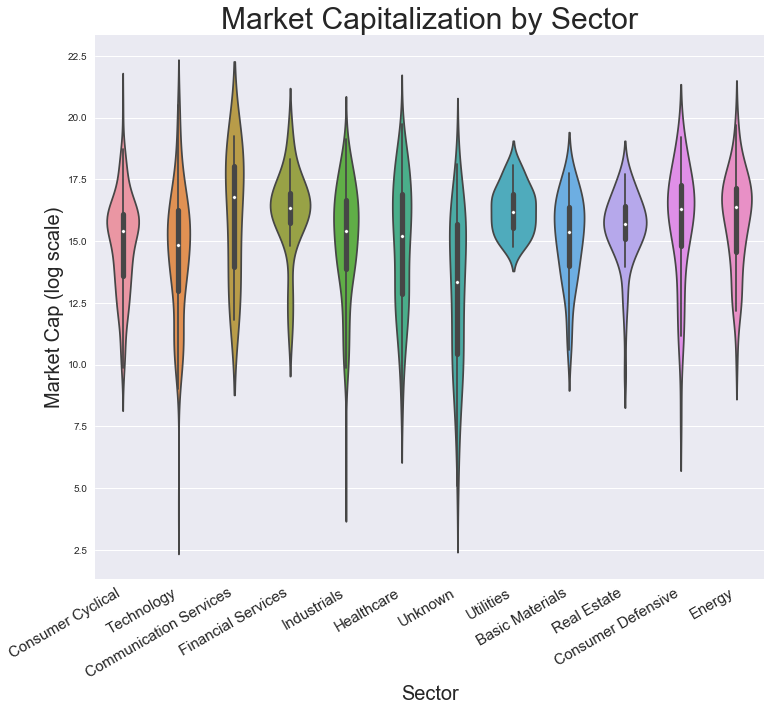

In [20]:
fig, ax = plt.subplots(figsize=(12,10))
sns.set_style("whitegrid")
ax = sns.violinplot(x="Sector", y="LogCap", data=X)
ax.set_xlabel("Sector", fontdict={'size':20})
ax.set_xticklabels(list(X['Sector'].unique()), fontdict={'size':15}, rotation=30, horizontalalignment='right')
ax.set_ylabel("Market Cap (log scale)", fontdict={'size': 20})
ax.set_title("Market Capitalization by Sector", fontdict={'size': 30})

In [14]:
cap_labels = X['Market Cap'].unique()
cap_std_devs = []
cap_means = []
cap_count = []
for label in cap_labels:
    cap_std_devs.append(np.sqrt(np.var(X[X['Market Cap'] == label]['Market Capitalisation']))/1000)
    cap_means.append(np.mean(X[X['Market Cap'] == label]['Market Capitalisation'])/1000)
    cap_count.append(X[X['Market Cap'] == label].shape[0])
cv = [i/j for i,j in zip(cap_std_devs, cap_means)]
cap_devs = pd.DataFrame(data= [cap_count,cap_std_devs, cap_means, cv], columns=cap_labels,\
                        index=['Count', 'Std Dev($Millions)', 'Cap Mean($Millions)', 'CV(Std Dev/Mean)'])

In [17]:
X.shape

(1004, 53)

In [15]:
cap_devs.round(3).T.sort_values(by='Std Dev($Millions)')

,Count,Std Dev($Millions),Cap Mean($Millions),CV(Std Dev/Mean)
Small,362.0,554.037,541.029,1.024
Mid,289.0,2190.281,5352.619,0.409
Large,336.0,35144.907,37505.001,0.937
Mega,17.0,217824.898,397960.709,0.547


/Users/kevinkaltenbacher/anaconda/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


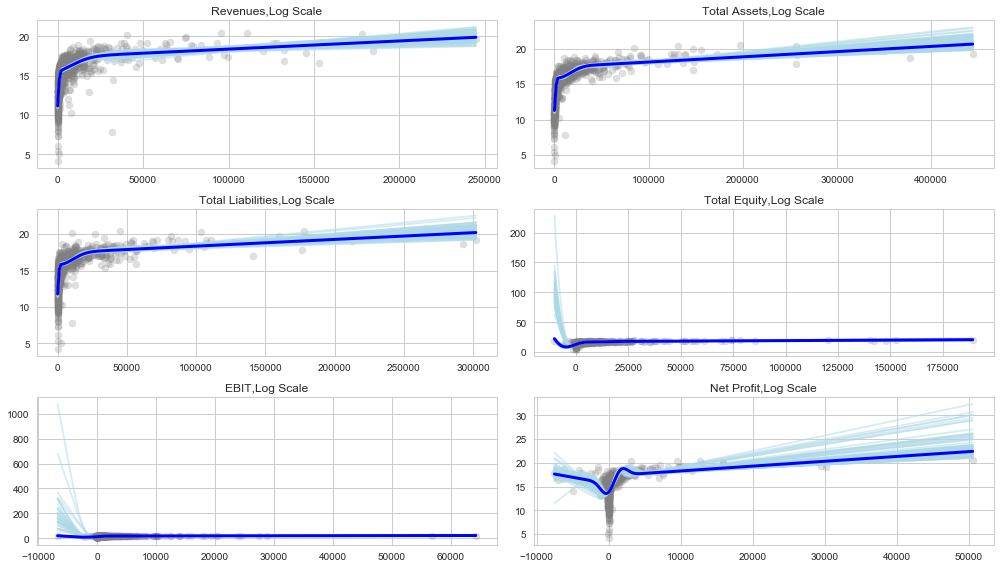

In [21]:
numerical_features = ['Revenues', 'Total Assets', 'Total Liabilities', 'Total Equity', 'EBIT', 'Net Profit']


fig, axs = plt.subplots(3, 2, figsize=(14, 8))
# univariate_plot_names = df_no_zeros[numerical_features]

for name, ax in zip(numerical_features, axs.flatten()):
    plot_univariate_smooth(ax,
                           X[name].values.reshape(-1, 1),
                           X['LogCap'],
                           bootstrap=100)
    ax.set_title(name + ",Log Scale")
fig.tight_layout()
plt.style.use('bmh')

In [ ]:
X_dummies = X.drop(['Market Cap','LogCap','Market Capitalisation'], axis=1)
X_dummies = pd.get_dummies(X_dummies)

In [24]:
X_dummies.shape

(1004, 68)

In [232]:
# Create data and train test split without cluster labels
X_no_clusters = X_dummies.drop([f'Clusters_{i}' for i in range(7)], axis=1)
X_train_nc, X_test_nc, y_train_nc, y_test_nc = train_test_split(X_no_clusters, y, test_size=0.30, random_state=42)
scaler_nc = StandardScaler()
scaler_nc.fit(X_train_nc)
X_train_scaled_nc = scaler_nc.transform(X_train_nc)
X_test_scaled_nc = scaler_nc.transform(X_test_nc)

In [171]:
#Train, test, split data for model training/validation and testing
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.30, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [317]:
score_types = ['root_mean_squared_error', 'r2']
train_sets = [X_train_scaled, X_train_scaled_nc]
test_sets = [X_test_scaled, X_test_scaled_nc]
y_sets = [y_train, y_test]
params = []
lin_reg = LinearRegression()

def get_scores(score_types, train_sets, test_sets, y_sets, model):
    rmse_list = []
    r2_list = []
    for score_type in score_types:
        for i, train_data in enumerate(train_sets):
            model.fit(train_data, y_sets[0])
            preds = model.predict(test_sets[i]) 
            if score_type == 'root_mean_squared_error':
                score_value = mean_squared_error(y_sets[1], preds)
                rmse_list.append(np.sqrt(score_value))
            else:
                score_value = model.score(test_sets[i], y_sets[1])
                r2_list.append(np.mean(score_value))
            
    score_df = pd.DataFrame(data=[rmse_list,r2_list], index= score_types,\
                            columns=['Clusters', 'No Clusters'])
    return score_df 

score_df = get_scores(score_types, train_sets, test_sets, y_sets, model)

In [318]:
score_df

,Clusters,No Clusters
root_mean_squared_error,2.482024e+07,2.486656e+07
r2,3.435447e-01,3.410920e-01


In [199]:
model.coef_

array([-2.19088910e+06, -6.78908448e+06,  1.19755315e+07,  2.61035634e+06,
        2.17873344e+14, -7.50704132e+13, -9.31185447e+06, -1.22739208e+06,
       -5.84740947e+13,  2.21170825e+06, -1.14574348e+07, -3.43589980e+06,
        1.31743218e+07,  9.33262165e+06, -4.98906670e+07,  1.26174813e+07,
        3.12184646e+06,  7.26839554e+06, -1.14713296e+08, -1.05909010e+08,
       -3.43086771e+06,  8.11777823e+06,  4.42825701e+07,  1.07491959e+07,
        4.22456963e+07,  4.86793240e+07,  4.95585303e+06,  3.27191459e+06,
        5.60424921e+06,  1.53192659e+06,  2.56898273e+07,  2.32645733e+06,
        5.88704816e+07,  9.48147390e+13,  1.32335033e+14, -5.40853414e+07,
        7.07114289e+13, -8.81970958e+07, -6.16918887e+07,  5.22604458e+07,
       -2.18169494e+14,  3.30357520e+05, -1.32998782e+06,  1.49840152e+06,
        1.05155872e+07,  3.05560950e+05,  4.43008966e+06,  1.06621683e+07,
       -4.83648865e+05,  1.71783361e+05, -3.73445008e+05, -3.60414798e+05,
        1.96627028e+06, -

In [200]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
preds = model.predict(X_test_scaled)
model_r2 = model.score(X_test_scaled, y_test)

In [201]:
model_r2

0.3435446953356811

In [202]:
model.coef_

array([-2.19088910e+06, -6.78908448e+06,  1.19755315e+07,  2.61035634e+06,
        2.17873344e+14, -7.50704132e+13, -9.31185447e+06, -1.22739208e+06,
       -5.84740947e+13,  2.21170825e+06, -1.14574348e+07, -3.43589980e+06,
        1.31743218e+07,  9.33262165e+06, -4.98906670e+07,  1.26174813e+07,
        3.12184646e+06,  7.26839554e+06, -1.14713296e+08, -1.05909010e+08,
       -3.43086771e+06,  8.11777823e+06,  4.42825701e+07,  1.07491959e+07,
        4.22456963e+07,  4.86793240e+07,  4.95585303e+06,  3.27191459e+06,
        5.60424921e+06,  1.53192659e+06,  2.56898273e+07,  2.32645733e+06,
        5.88704816e+07,  9.48147390e+13,  1.32335033e+14, -5.40853414e+07,
        7.07114289e+13, -8.81970958e+07, -6.16918887e+07,  5.22604458e+07,
       -2.18169494e+14,  3.30357520e+05, -1.32998782e+06,  1.49840152e+06,
        1.05155872e+07,  3.05560950e+05,  4.43008966e+06,  1.06621683e+07,
       -4.83648865e+05,  1.71783361e+05, -3.73445008e+05, -3.60414798e+05,
        1.96627028e+06, -

In [233]:
model = LinearRegression()
model.fit(X_train_scaled_nc, y_train_nc)
preds = model.predict(X_test_scaled_nc)
model_r2 = model.score(X_test_scaled_nc, y_test_nc)
model_r2

0.34109199269546553

In [234]:
scores_nc = cross_val_score(model, X_train_scaled_nc, y_train_nc, cv=5, scoring='neg_mean_squared_error')
rmse_list_nc = [np.sqrt(-score) for score in scores_nc]
np.mean(rmse_list_nc)

44508120.53931172

In [178]:
rfr = RandomForestRegressor(n_estimators=100)
gb = GradientBoostingRegressor()
svm = SVR()
model_list = [rfr, gb, svm]

In [179]:
rfr.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [180]:
rfr.score(X_test_scaled, y_test)

0.6506770767207788

In [237]:
def gridsearch(model, params, score_type, data):
    X_train, y_train, X_test, y_test = data[0], data[1], data[2], data[3]
    model = GridSearchCV(model, param_grid=params, scoring=score_type, n_jobs=-1, cv=5, verbose=1)
    model.fit(X_train, y_train)
    best_params = model.best_params_
    score = model.best_estimator_.score(X_test, y_test)

    return model, best_params, score

In [319]:
data = X_train_scaled, y_train, X_test_scaled, y_test
gridsearch_model = RandomForestRegressor()

l_max_features = [10]
l_n_estimators = [450]
l_max_leaf_nodes = [100]
l_min_samples_leaf = [5]
l_min_samples_split = [10]

params = {'max_features': l_max_features,
'n_estimators': l_n_estimators,
'max_leaf_nodes': l_max_leaf_nodes, 
'min_samples_leaf': l_min_samples_leaf,
'min_samples_split': l_min_samples_split}
score_type = 'neg_mean_squared_error'
best_rfr, best_rfr_p, best_rfr_score = gridsearch(gridsearch_model, params, score_type, data)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.7s remaining:    2.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.8s finished


In [320]:
best_rfr_score

0.6529552902994109

In [321]:
best_rfr_p

{'max_features': 10,
 'max_leaf_nodes': 100,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 450}

In [ ]:
rfr_model = RandomForestRegressor(max_features = 10, n_estimators = 450, max_leaf_nodes = 100,\
                                    min_samples_leaf = 5, min_samples_split = 10)
rfr_score_df = get_scores(score_types, train_sets, test_sets, y_sets, rfr_model)

In [323]:
rfr_score_df

,Clusters,No Clusters
root_mean_squared_error,1.811577e+07,1.975716e+07
r2,6.198490e-01,6.318508e-01


In [185]:
# Gradient Boosting grid search
l_learning_rate = [0.1]
l_n_estimators = [50, 60, 100]
l_max_depth = [3]
l_min_samples_leaf = [17]
l_min_samples_split = [20]
l_max_features = [None]

params = {'learning_rate': l_learning_rate,
'n_estimators': l_n_estimators,
'max_depth': l_max_depth, 
'min_samples_leaf': l_min_samples_leaf,
'min_samples_split': l_min_samples_split}

best_gb, best_gb_p, best_gb_score = gridsearch(gb, params, data)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    0.6s finished


In [186]:
best_gb_score

0.6138888474256514

In [187]:
best_gb_p

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_samples_leaf': 17,
 'min_samples_split': 20,
 'n_estimators': 50}

In [324]:
gb_model = GradientBoostingRegressor(learning_rate = 0.1, n_estimators = 50, max_depth = 3, min_samples_leaf = 17, \
                                        min_samples_split = 20, max_features = None)
gb_score_df = get_scores(score_types, train_sets, test_sets, y_sets, gb_model)
gb_score_df

,Clusters,No Clusters
root_mean_squared_error,1.903529e+07,1.903529e+07
r2,6.138888e-01,6.138888e-01


In [ ]:
gridsearch_model = SVR()

l_max_features = [10]
l_n_estimators = [450]
l_max_leaf_nodes = [100]
l_min_samples_leaf = [5]
l_min_samples_split = [10]

params = {'max_features': l_max_features,
'n_estimators': l_n_estimators,
'max_leaf_nodes': l_max_leaf_nodes, 
'min_samples_leaf': l_min_samples_leaf,
'min_samples_split': l_min_samples_split}

best_rfr, best_rfr_p, best_rfr_score = gridsearch(gridsearch_model, params, data)

In [325]:
def feat_importance_plot(model,names,filename,color='g',alpha=0.5,fig_size=(10,10),dpi=250):
    '''
    horizontal bar plot of feature importances
    works for sklearn models that have a .feature_importances_ method (e.g. RandomForestRegressor)

    imputs
    ------
    model:    class:     a fitted sklearn model
    names:    list:      list of names for all features
    filename: string:    name of file to write, with appropriate path and extension (e.g. '../figs/feat_imp.png')

    optional imputs to control plot
    ---------------
    color(default='g'), alpha(default=0.8), fig_size(default=(10,10)), dpi(default=250)

    '''
    ft_imp = 100*model.feature_importances_ / np.sum(model.feature_importances_) # funny cause they sum to 1
    ft_imp_srt, ft_names, ft_idxs = zip(*sorted(zip(ft_imp, names, range(len(names)))))

#     idx = np.arange(len(names))
    idx = np.arange(10)
    plt.figure(figsize=(10,10))
    plt.barh(idx, ft_imp_srt[-11:-1], align='center', color=color,alpha=alpha)
    plt.yticks(idx, ft_names[-11:-1], fontsize=12)

    plt.title("Top 10 Feature Importances from {}".format(model.__class__.__name__),fontsize=20)
    plt.xlabel('Relative Importance of Feature', fontsize=14)
#     plt.ylabel('Feature Name', fontsize=14)
    plt.savefig(filename,dpi=dpi)
    plt.show()

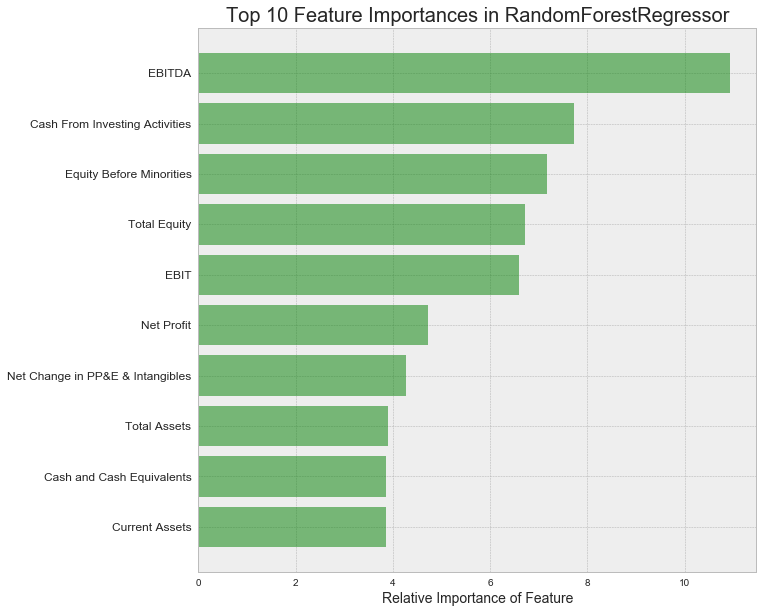

In [326]:
best_rfr_features = best_rfr.best_estimator_.fit(X_train_scaled, y_train)
feature_names=[col for col in X_dummies.columns]
feat_importance_plot(best_rfr_features,feature_names,'best_feats',color='g',alpha=0.5,fig_size=(10,10),dpi=250)

In [329]:
rfr_preds = np.array(best_rfr_features.predict(X_test_scaled))
y_actual = np.array(y_test)

In [330]:
rfr_preds.shape[0] == y_actual.shape[0]

True

In [367]:
root_sq_errors = np.sqrt((rfr_preds - y_actual)**2)/ y_actual

In [368]:
error_idxs = np.argsort(root_sq_errors)

In [387]:
top_30_mean_error = np.mean(root_sq_errors[error_idxs[0:30]])
top_30_stocks = list(X_test.index[error_idxs[0:30]])
top_30_market_cap = X.loc[top_30_stocks]['Market Cap']
top_30_sectors = X.loc[top_30_stocks]['Sector']

In [388]:
top_30_mean_error

0.03948063250736189

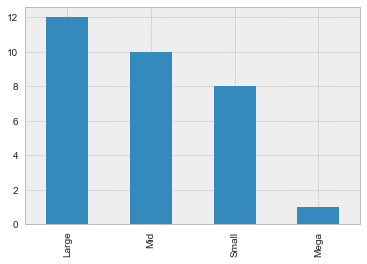

In [385]:
top_30_market_cap.value_counts().plot(kind='bar')

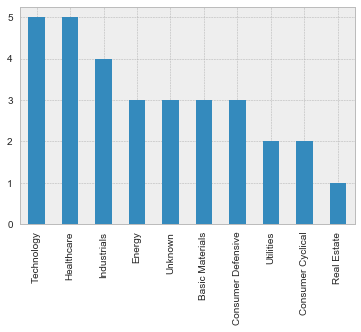

In [386]:
top_30_sectors.value_counts().plot(kind='bar')

In [393]:
bottom_30_mean_error = np.mean(root_sq_errors[error_idxs[-31:-1]])
bottom_30_stocks = list(X_test.index[error_idxs[-31:-1]])
bottom_30_market_cap = X.loc[bottom_30_stocks]['Market Cap']
bottom_30_sectors = X.loc[bottom_30_stocks]['Sector']

In [394]:
bottom_30_mean_error

6.723762665750028

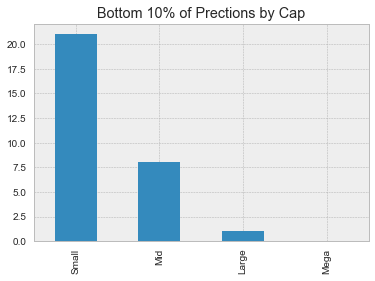

In [399]:
bottom_30_market_cap.value_counts().plot(kind='bar', title='Bottom 10% of Prections by Cap')

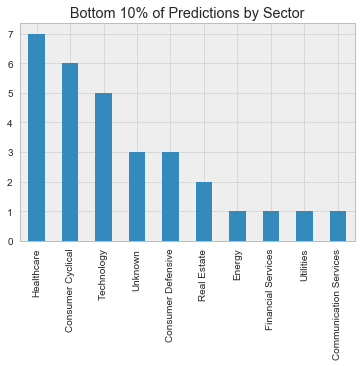

In [400]:
bottom_30_sectors.value_counts().plot(kind='bar', title='Bottom 10% of Predictions by Sector')